In [1]:
!git clone https://github.com/harveyslash/Facial-Similarity-with-Siamese-Networks-in-Pytorch.git
!mkdir data
!mv Facial-Similarity-with-Siamese-Networks-in-Pytorch/data/faces/testing/* data/
!mv Facial-Similarity-with-Siamese-Networks-in-Pytorch/data/faces/training/* data/

fatal: destination path 'Facial-Similarity-with-Siamese-Networks-in-Pytorch' already exists and is not an empty directory.
mkdir: cannot create directory ‘data’: File exists
mv: cannot stat 'Facial-Similarity-with-Siamese-Networks-in-Pytorch/data/faces/testing/*': No such file or directory
mv: cannot stat 'Facial-Similarity-with-Siamese-Networks-in-Pytorch/data/faces/training/*': No such file or directory


In [2]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
import glob

from aijack.attack import MI_FACE
from aijack.defense import GeneralMomentAccountant, DPSGDManager
from aijack.utils import NumpyDataset

BASE = "data/"

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fla = nn.Flatten()
        self.fc = nn.Linear(112 * 92, 40)

    def forward(self, x):
        x = self.fla(x)
        x = self.fc(x)
        x = F.softmax(x, dim=1)
        return x

In [4]:
imgs = []
labels = []
for i in range(1, 41):
    for j in range(1, 11):
        img = cv2.imread(BASE + f"s{i}/{j}.pgm", 0)
        imgs.append(img)
        labels.append(i - 1)

X = np.stack(imgs)
y = np.array(labels)

# ToTensor：画像のグレースケール化（RGBの0~255を0~1の範囲に正規化）、Normalize：Z値化（RGBの平均と標準偏差を0.5で決め打ちして正規化）
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
trainset = NumpyDataset(X, y, transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=4, shuffle=True, num_workers=2
)

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)

In [5]:
lot_size = 40
batch_size = 1
iterations = 10
sigma = 0.5
l2_norm_clip = 1
delta = 1e-5

accountant = GeneralMomentAccountant(
    noise_type="Gaussian",
    search="ternary",
    precision=0.001,
    order_max=1,
    order_min=72,
    max_iterations=1000,
    bound_type="rdp_upperbound_closedformula",
    backend="python",
)

privacy_manager = DPSGDManager(
    accountant,
    optim.SGD,
    l2_norm_clip=l2_norm_clip,
    dataset=trainset,
    lot_size=lot_size,
    batch_size=batch_size,
    iterations=iterations,
)

accountant.reset_step_info()
accountant.add_step_info(
    {"sigma": sigma},
    lot_size / len(trainset),
    iterations * (len(trainset) / lot_size),
)
estimated_epsilon = accountant.get_epsilon(delta=delta)
print(f"estimated epsilon is {estimated_epsilon}")

accountant.reset_step_info()
dpoptimizer_cls, lot_loader, batch_loader = privacy_manager.privatize(
    noise_multiplier=sigma
)

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = dpoptimizer_cls(net.parameters(), lr=0.05, momentum=0.9)

for epoch in range(iterations):  # loop over the dataset multiple times
    running_loss = 0
    data_size = 0
    preds = []
    labels = []

    for X_lot, y_lot in lot_loader(optimizer):
        for X_batch, y_batch in batch_loader(TensorDataset(X_lot, y_lot)):
            optimizer.zero_grad()
            pred = net(X_batch)
            loss = criterion(pred, y_batch.to(torch.int64))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            data_size += X_batch.shape[0]
            preds.append(pred)
            labels.append(y_batch)

    preds = torch.cat(preds)
    labels = torch.cat(labels)
    print(f"epoch {epoch}: loss is {running_loss/data_size}")

print(f"final epsilon is {accountant.get_epsilon(delta=delta)}")


estimated epsilon is 35.14997033525656
epoch 0: loss is 3.681786752056766
epoch 1: loss is 3.6322441777273613
epoch 2: loss is 3.531550452547166
epoch 3: loss is 3.4048857342223733
epoch 4: loss is 3.279353316739309
epoch 5: loss is 3.147891944130355
epoch 6: loss is 3.0829262246665157
epoch 7: loss is 3.0064322753487347
epoch 8: loss is 2.9347370161394184
epoch 9: loss is 2.9120311971570625
final epsilon is 35.14997033525652


In [6]:
in_preds = []
in_label = []
with torch.no_grad():
    for data in trainloader:
        inputs, labels = data
        outputs = net(inputs)
        in_preds.append(outputs)
        in_label.append(labels)
    in_preds = torch.cat(in_preds)
    in_label = torch.cat(in_label)
print(
    "Test Accuracy is: ",
    accuracy_score(np.array(torch.argmax(in_preds, axis=1)), np.array(in_label)),
)

Test Accuracy is:  0.91


In [7]:
input_shape = (1, 1, 112, 92)
target_label = 11
lam = 0.03
num_itr = 100

mi = MI_FACE(
    net,
    input_shape,
    target_label=target_label,
    num_itr=num_itr,
    lam=lam,
    log_interval=0,
)
x_result_1, log = mi.attack()

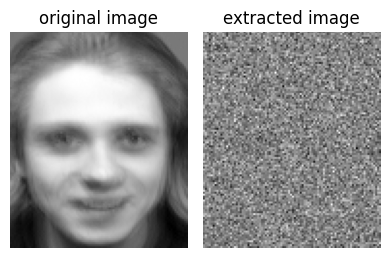

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(4, 3))
axes[0].imshow(
    np.mean([cv2.imread(p, 0) for p in glob.glob(BASE + "s12/*.pgm")], axis=0),
    cmap="gray",
)
axes[0].axis("off")
axes[0].set_title("original image")
axes[1].imshow(x_result_1[0][0].detach().numpy(), cmap="gray")
axes[1].axis("off")
axes[1].set_title("extracted image")
fig.tight_layout()
fig.show()